In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class mapas:
    '''Clase para visualizar datos de iluminancia.

    Esta clase proporciona métodos para leer datos de iluminancia, calcular el índice de distribución útil de la luz del día (UDI), y visualizar mapas de iluminancia y UDI.

    Atributos:
    ----------
    file_path : str
        Ruta del archivo que contiene los datos de iluminancia.
    matrix_shape : tuple of int
        Tamaño de la matriz para representar los datos de iluminancia (por defecto es (20, 10)).
    data : pandas.DataFrame
        Datos de iluminancia leídos del archivo.
    matrices : pandas.Series
        Serie de matrices que representan los datos de iluminancia para cada tiempo.
    udi_maps : dict
        Diccionario que contiene los mapas UDI para "UDI_sub", "UDI_util" y "UDI_sobre".

    Métodos:
    --------
    _calculate_udi(illum_min=300, illum_max=2000)
        Calcula los mapas UDI (sub, util, sobre) para el rango especificado de iluminancia.
    visualize_udi(illum_min=300, illum_max=2000, cmap='jet', num_levels=10)
        Visualiza los mapas UDI con los valores de iluminancia especificados.
    visualize_illuminance(datetime_str, cmap="jet", vmin=0, vmax=3000)
        Visualiza la matriz de iluminancia para una fecha y hora específica.'''

    def __init__(self, file_path):
        '''
        Inicializa una instancia de IlluminanceDataVisualizer.

        Parámetros:
        -----------
        file_path : str
            Ruta del archivo que contiene los datos de iluminancia.
        matrix_shape : tuple of int, opcional
            Tamaño de la matriz para representar los datos de iluminancia (por defecto es (20, 10)).
        '''
        self.file_path = file_path
        self._generate_grid_from_header()

        # self.matrix_shape = matrix_shape
        self.data = None
        self.matrices = None
        self.udi_maps = None
    
        # Leer el archivo, omitir las primeras cuatro filas de encabezado
        try:
            self.data = pd.read_csv(self.file_path, skiprows=4, header=None, engine='python')
        except pd.errors.ParserError as e:
            raise ValueError(f"Error al leer el archivo: {e}")
        
        # Crear columna datetime
        self.data["fecha"] = self.data[0].astype(str) + "-" + self.data[1].astype(str) + "-" + "2024" + " " + self.data[2]
        self.data["fecha"] = pd.to_datetime(self.data["fecha"], format="%m-%d-%Y %H:%M:%S")
        self.data.set_index("fecha", inplace=True)
        
        # Eliminar columnas innecesarias
        self.data.drop(columns=[0, 1, 2, 3, 4, 5], inplace=True)
        
        # Convertir cada renglón a una matriz del tamaño especificado
        self.matrices = self.data.apply(lambda row: np.array(row).reshape(self.matrix_shape), axis=1)


    
    
    def _generate_grid_from_header(self):
        """
        Genera un grid de coordenadas X e Y y determina la forma de la matriz de datos a partir del encabezado del archivo.
        """
        # Leer el encabezado del archivo para extraer los datos relevantes
        with open(self.file_path, 'r') as file:
            header_lines = [file.readline().strip() for _ in range(4)]
        
        # Extraer información del encabezado (línea 4, índice 3)
        header_data = header_lines[3].split()
        
        # Convertir los datos del encabezado en valores numéricos
        xmin, ymin, _, xmax, _, _, _, ymax, _, xspacing, yspacing = map(float, header_data)
        
        # Determinar el número de puntos en cada dirección
        num_x_points = int(((xmax - xmin) / xspacing)) 
        num_y_points = int(((ymax - ymin) / yspacing)) 
        
        # Actualizar la forma de la matriz
        self.matrix_shape = (num_y_points, num_x_points)
        
        # Crear las coordenadas X e Y usando linspace
        x_coords = np.linspace(xmin, xmax, num_x_points)
        y_coords = np.linspace(ymin, ymax, num_y_points)
        
        # Crear el grid usando meshgrid
        x_grid, y_grid = np.meshgrid(x_coords, y_coords)
        self.XX = x_grid
        self.YY = y_grid
        self.aspect_ratio = (self.YY.max() - self.YY.min()) / (self.XX.max() - self.XX.min())

            
        
        # # Ejemplo de uso
        # file_path = 'ruta/al/archivo.csv'
        # x_grid, y_grid = generate_grid_from_header(file_path)


    def _calculate_udi(self, illum_min=300, illum_max=2000):
        '''Calcula los índices de distribución útil de la luz del día (UDI).

        Parámetros:
        -----------
        illum_min : int, opcional
            Valor mínimo de iluminancia para considerar como UDI útil (por defecto es 300).
        illum_max : int, opcional
            Valor máximo de iluminancia para considerar como UDI útil (por defecto es 2000).

        Lanza:
        -------
        ValueError
            Si la suma de los tres UDI no es igual a 100 en todos los puntos de la matriz.'''
        # Filtrar las horas de 8 a 18
        filtered_data = self.data.between_time("08:00", "18:00")
        total_hours = len(filtered_data)
        
        # Inicializar matrices para UDI_sub, UDI_util, UDI_sobre
        udi_sub = np.zeros(self.matrix_shape)
        udi_util = np.zeros(self.matrix_shape)
        udi_sobre = np.zeros(self.matrix_shape)
        
        # Iterar sobre cada fila y calcular UDI
        for _, row in filtered_data.iterrows():
            matrix = np.array(row).reshape(self.matrix_shape)
            udi_sub += (matrix < illum_min).astype(int)
            udi_util += ((matrix >= illum_min) & (matrix <= illum_max)).astype(int)
            udi_sobre += (matrix > illum_max).astype(int)
        
        # Calcular porcentaje de tiempo en cada rango
        self.udi_maps = {
            "UDI_sub": (udi_sub / total_hours) * 100,
            "UDI_util": (udi_util / total_hours) * 100,
            "UDI_sobre": (udi_sobre / total_hours) * 100
        }
        
        # Comprobación de que la suma de los tres UDI es 100
        udi_sum_check = self.udi_maps["UDI_sub"] + self.udi_maps["UDI_util"] + self.udi_maps["UDI_sobre"]
        if not np.allclose(udi_sum_check, 100, atol=1e-2):
            raise ValueError("La suma de los UDI no es igual a 100 en todos los puntos de la matriz.")

 
    def visualize_udi(self, illum_min=300, illum_max=2000, cmap='jet', num_levels=10):
        '''Visualiza los mapas de UDI (sub, util, sobre).
    
        Parámetros:
        -----------
        illum_min : int, opcional
            Valor mínimo de iluminancia para considerar como UDI útil (por defecto es 300).
        illum_max : int, opcional
            Valor máximo de iluminancia para considerar como UDI útil (por defecto es 2000).
        cmap : str, opcional
            Mapa de colores a utilizar en la visualización (por defecto es 'jet').
        num_levels : int, opcional
            Número de niveles de color para el colorbar (por defecto es 10).'''
        # Recalcular UDI si los valores de illum_min o illum_max son diferentes a los predeterminados
        self._calculate_udi(illum_min, illum_max)
        
        # Graficar los resultados de UDI
        
        labels = [f"UDI < {illum_min}", f"{illum_min} <= UDI <= {illum_max}", f"UDI > {illum_max}"]
        fig, axes = plt.subplots(1, 3, figsize=(10,10*self.aspect_ratio/1.8))
        
        for i, (label, key) in enumerate(zip(labels, self.udi_maps.keys())):
            ax = axes[i]
            norm = plt.Normalize(vmin=0, vmax=100)
            # cax = ax.imshow(self.udi_maps[key], cmap=cmap, norm=norm)
            cax = ax.pcolormesh(self.XX, self.YY, self.udi_maps[key], cmap=cmap, vmin=0, vmax=100)
                # ax.set_aspect(aspect_ratio)  # Ajusta el aspecto del gráfico
            ax.set_title(label)
            # ax.set_xticks(np.arange(0, self.matrix_shape[1], 1))
            # ax.set_yticks(np.arange(0, self.matrix_shape[0], 1))

        # Mejorar el colorbar
        cbar = fig.colorbar(
            cax, 
            ax=axes.ravel().tolist(), 
            orientation='horizontal', 
            fraction=0.15,   # Reduce el tamaño del colorbar
            pad=0.15,         # Espacio entre los subplots y el colorbar
            ticks=np.linspace(0, 100, num_levels + 1), 
            boundaries=np.linspace(0, 100, num_levels),
            aspect=35
        )        
        cbar.set_label('UDI [% de tiempo]')
        
        plt.show()
        return fig, axes

    def visualize_illuminance(self, datetime_str, cmap="jet", vmin=0, vmax=3000):
        '''Visualiza la matriz de iluminancia para una fecha y hora específica, considerando la razón de aspecto del grid.
    
        Parámetros:
        -----------
        datetime_str : str
            Fecha y hora en formato 'YYYY-MM-DD HH:MM:SS' para la cual se desea visualizar la matriz de iluminancia.
        cmap : str, opcional
            Mapa de colores a utilizar en la visualización (por defecto es 'jet').
        vmin : int, opcional
            Valor mínimo para el mapa de colores (por defecto es 0).
        vmax : int, opcional
            Valor máximo para el mapa de colores (por defecto es 3000).'''
        # Obtener la matriz para la fecha y hora especificada
        if datetime_str not in self.matrices:
            raise ValueError(f"Datetime {datetime_str} not found in the data.")
        
        matrix = self.matrices[datetime_str]
        
        # Calcular la razón de aspecto
        aspect_ratio = (self.YY.max() - self.YY.min()) / (self.XX.max() - self.XX.min())
        
        # Graficar la matriz utilizando XX y YY para definir el grid
        fig, ax = plt.subplots(figsize=(8,8* aspect_ratio))
        cax = ax.pcolormesh(self.XX, self.YY, matrix, cmap=cmap, vmin=vmin, vmax=vmax)
        cbar = fig.colorbar(cax, ax=ax)
        cbar.set_label('Illuminancia [lux]')
        plt.title(f'{datetime_str}')
        plt.show()



In [157]:
mapa = mapas('../data/Space_101_map.ill')

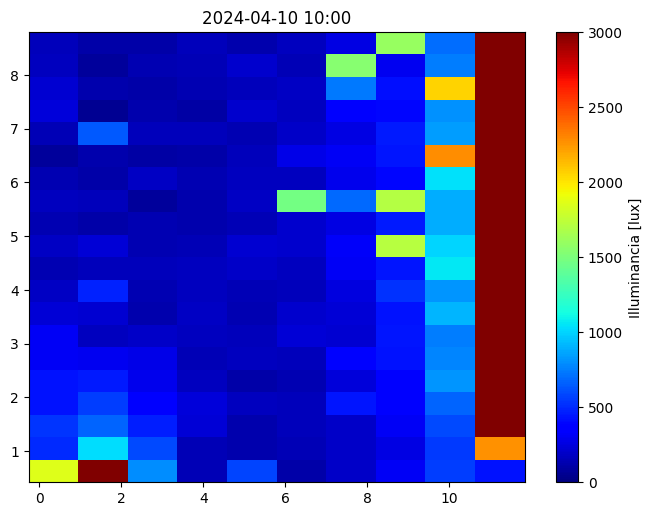

In [158]:
mapa.visualize_illuminance('2024-04-10 10:00')

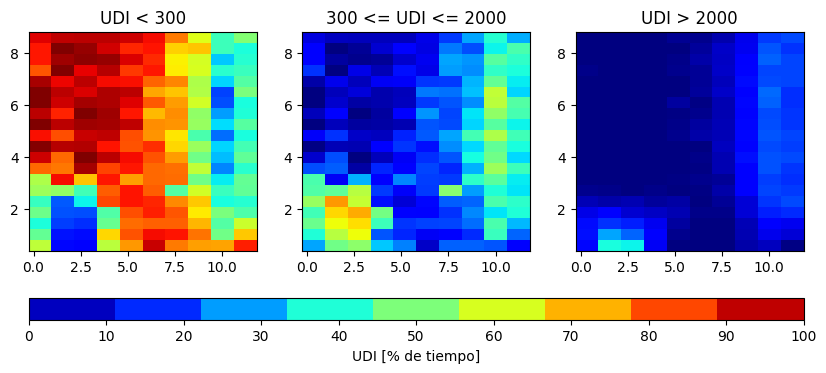

(<Figure size 1000x406.11 with 4 Axes>,
 array([<Axes: title={'center': 'UDI < 300'}>,
        <Axes: title={'center': '300 <= UDI <= 2000'}>,
        <Axes: title={'center': 'UDI > 2000'}>], dtype=object))

In [159]:
mapa.visualize_udi()